# *Goal* :
* To build a recommendation engine that automatically recommends a certain number of products to the consumers on an E-commerce website based on the past purchase behavior of the consumers

# *Data* :
* The E-Commerce data is taken from the UCI repository and can be found [here](https://archive.ics.uci.edu/ml/machine-learning-databases/00352/)

## Dataset summary

https://archive.ics.uci.edu/dataset/352/online+retail

# *Solution* :
* Implemented Word2Vec model in NLP to form word embeddings for all the products
* Recommend top 'n' products for a customer based on the similarity of vectors between his purchased products and the entire products in the site

# *Code and Implementation* :
* The entire code is given in my github [repo](https://github.com/sravanroy/RecommendationSystem-Word2vec)
* The breakdown and implementation of the code is given below

### Loading the required libraries

In [1]:
import pandas as pd
import numpy as np
import random
from tqdm import tqdm
from gensim.models import Word2Vec 
import matplotlib.pyplot as plt
%matplotlib inline

import warnings;
warnings.filterwarnings('ignore')

### Reading the E-commerce data

In [2]:
df = pd.read_excel('Online_Retail.xlsx')
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


### Data Preprocessing

In [3]:
# check for missing values
df.isnull().sum()

# remove missing values
df.dropna(inplace=True)

#convert stock_code to string type since it's a unique combinations of numbers and letters
df['StockCode']= df['StockCode'].astype(str)

In [4]:
df.describe(include='all')

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
count,406829.0,406829,406829,406829.000000,406829,406829.000000,406829.000000,406829
unique,22190.0,3684,3896,NaN,20460,NaN,NaN,37
top,576339.0,85123A,WHITE HANGING HEART T-LIGHT HOLDER,NaN,2011-11-14 15:27:00,NaN,NaN,United Kingdom
freq,542.0,2077,2070,NaN,543,NaN,NaN,361878
first,NaN,NaN,NaN,NaN,2010-12-01 08:26:00,NaN,NaN,NaN
last,NaN,NaN,NaN,NaN,2011-12-09 12:50:00,NaN,NaN,NaN
mean,NaN,NaN,NaN,12.061303,NaN,3.460471,15287.690570,NaN
std,NaN,NaN,NaN,248.693370,NaN,69.315162,1713.600303,NaN
min,NaN,NaN,NaN,-80995.000000,NaN,0.000000,12346.000000,NaN
25%,NaN,NaN,NaN,2.000000,NaN,1.250000,13953.000000,NaN


### Train and Validation split

In [5]:
customers = df['CustomerID'].unique().tolist()

# shuffle customer ID's
random.shuffle(customers)

# extract 90% of customer ID's
customers_train = [customers[i] for i in range(round(0.9*len(customers)))]

# split data into train and validation set
train_df = df[df['CustomerID'].isin(customers_train)]
validation_df = df[~df['CustomerID'].isin(customers_train)]

### Create sequences of purchases made by the customers

In [17]:
# list to capture purchase history of the customers
purchases_train = []

user_purchase_products = []

# populate the list with the product codes
for i in tqdm(customers_train):
    temp = train_df[train_df["CustomerID"] == i]["StockCode"].tolist()
    purchases_train.append(temp)
    user_purchase_products.append(len(temp))

print(
    'number of users : ',
    len(purchases_train),

    'purchased items distribution : ',
    pd.Series(user_purchase_products).describe([i/10 for i in range(0,11)]),
    sep='\n'
)

100%|██████████████████████████████████████████████████████| 3935/3935 [00:03<00:00, 1106.31it/s]

number of users : 
3935
purchased items distribution : 
count    3935.000000
mean       93.658196
std       241.177948
min         1.000000
0%          1.000000
10%         7.000000
20%        14.000000
30%        21.000000
40%        29.600000
50%        42.000000
60%        58.000000
70%        85.000000
80%       123.000000
90%       209.600000
100%     7983.000000
max      7983.000000
dtype: float64


In [19]:
# list to capture purchase history of the customers
purchases_val = []

user_purchase_products = []

# populate the list with the product codes
for i in tqdm(validation_df['CustomerID'].unique()):
    temp = validation_df[validation_df["CustomerID"] == i]["StockCode"].tolist()
    purchases_val.append(temp)
    user_purchase_products.append(len(temp))
    

print(
    'number of users : ',
    len(purchases_train),

    'purchased items distribution : ',
    pd.Series(user_purchase_products).describe([i/10 for i in range(0,11)]),
    sep='\n'
)

100%|████████████████████████████████████████████████████████| 437/437 [00:00<00:00, 1678.84it/s]

number of users : 
3935
purchased items distribution : 
count     437.000000
mean       87.606407
std       130.098395
min         1.000000
0%          1.000000
10%         8.000000
20%        15.000000
30%        21.000000
40%        29.000000
50%        41.000000
60%        59.000000
70%        83.200000
80%       130.000000
90%       220.800000
100%     1508.000000
max      1508.000000
dtype: float64


### Build Word2Vec embeddings for products

In [20]:
# train word2vec model
# docs
# https://radimrehurek.com/gensim/models/word2vec.html
# rule of thumb 
# https://code.google.com/archive/p/word2vec/

# Window - window of words 
# sg =1 (skip-gram), sg=0 CBOW
# architecture: skip-gram (slower, better for infrequent words) vs CBOW (fast)

# hs = 1 hierarchical softmax is used or not hs=0

# negtive : negative sampling words is used, usually 5~20 for small scale, 2~5 for large scale
# https://python5566.wordpress.com/2018/03/17/nlp-%E7%AD%86%E8%A8%98-negative-sampling/comment-page-1/

# 給定的 window，除了正確答案外，也要有錯誤答案，這類似於 data augmentation，只是不是經由資料量的方式來操作
# 而是直接透過 sample 正確字以外的 n 的 word ， 作為 -1, positive 作為 +1, 其餘作為 0
# 直接在更新參數的過程中操作，就不會拖慢訓練速度
# 隨機抽樣是一種方法，另一種方式則是根據字頻 (word frequency) 來抽樣，越高頻出現的字，越可以作為 negtive sample
# 理由是，高頻字在文本中會常常出現，那麼如果不是正確答案，就會是個質量更好的 negtive sample

# alpha

# init learning rate

# min_alpha (float, optional) – Learning rate will linearly drop to min_alpha as training progresses.

# vector_size=100 這也是可以調整的

# Evaluation

# https://github.com/arsena-k/Word2Vec-bias-extraction/blob/master/Part_A_W2V_training_performance_exploring.ipynb

# eyeball test
# 1. eval the selected word, check most-similar
# 2. check the most-not-similar
# 3. check anaology

model = Word2Vec(window = 10, sg = 1, hs = 0,
                 negative = 10, # for negative sampling
                 alpha=0.03, min_alpha=0.0007,
                 seed = 14)

model.build_vocab(purchases_train, progress_per=200)

model.train(purchases_train, total_examples = model.corpus_count, 
            epochs=10, report_delay=1)

(3649018, 3685450)

In [21]:
model.init_sims(replace=True)
print(model)


Word2Vec(vocab=3187, size=100, alpha=0.03)


### Extract the vectors for all words

In [22]:
# extract all vectors
X = model[model.wv.vocab]

X.shape

(3187, 100)

### Visualize word2vec embeddings by reducing dimensions using tSNE

In [23]:
from sklearn.manifold import TSNE

In [24]:
def tsne_plot(model):
    "Creates and TSNE model and plots it"
    labels = []
    tokens = []

    for word in model.wv.vocab:
        tokens.append(model[word])
        labels.append(word)
    
    tsne_model = TSNE(perplexity=40, n_components=2, init='pca', n_iter=2500, random_state=23)
    new_values = tsne_model.fit_transform(tokens)

    x = []
    y = []
    for value in new_values:
        x.append(value[0])
        y.append(value[1])
        
    plt.figure(figsize=(16, 16)) 
    for i in range(len(x)):
        plt.scatter(x[i],y[i])
        plt.annotate(labels[i],
                     xy=(x[i], y[i]),
                     xytext=(5, 2),
                     textcoords='offset points',
                     ha='right',
                     va='bottom')
    plt.show()

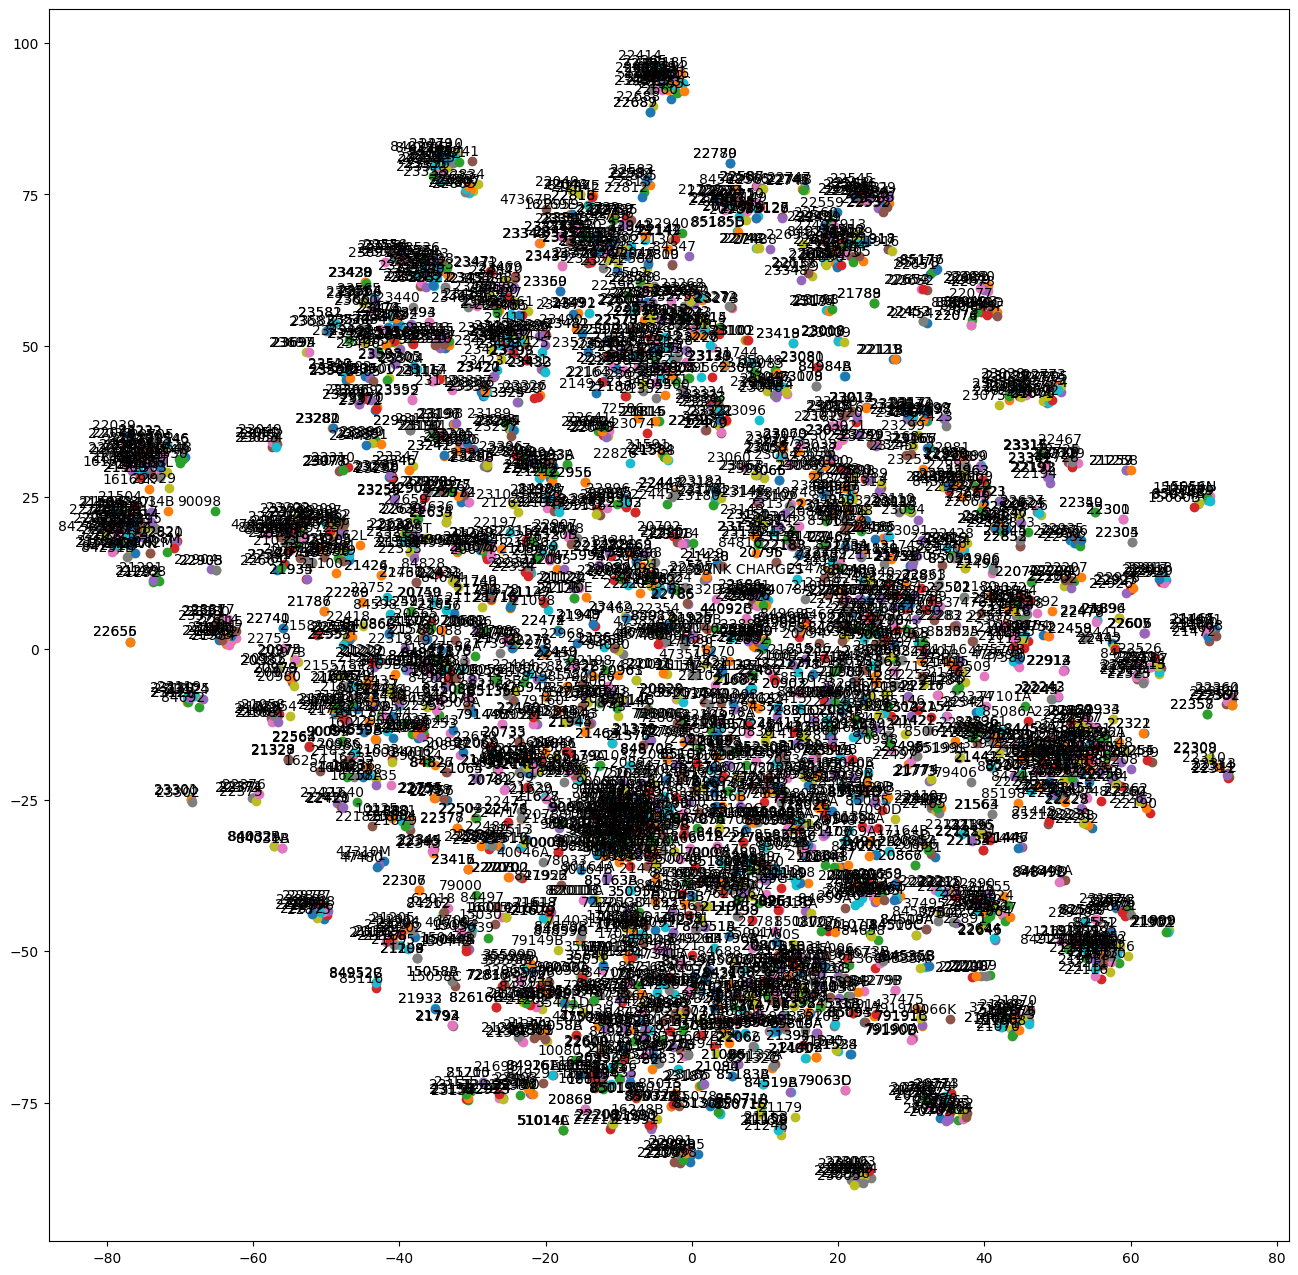

In [25]:
tsne_plot(model)

## Product Recommendations

### Creating a product ID-Description dictionary

In [26]:
products = train_df[["StockCode", "Description"]]

# remove duplicates
products.drop_duplicates(inplace=True, subset='StockCode', keep="last")

# create product-ID and product-description dictionary
products_dict = products.groupby('StockCode')['Description'].apply(list).to_dict()

### Function to return top 6 products based on a purchase

In [34]:
def similar_products(v, n = 6):
    
    # extract most similar products for the input vector
    ms = model.similar_by_vector(v, topn= n+1)[1:]
    
    # extract name and similarity score of the similar products
    new_ms = []
    for j in ms:
        pair = (products_dict[j[0]][0], j[1])
        new_ms.append(pair)
        
    return new_ms


### Test recommendations for a product 16218 ("CARTOON PENCIL SHARPENER")

In [35]:
similar_products(model['16218'])

[('HOUSE SHAPE PENCIL SHARPENER', 0.7291156053543091),
 ('PIECE OF CAMO STATIONERY SET', 0.7041822671890259),
 ('POPART WOODEN PENCILS ASST', 0.6975011825561523),
 ('LETTER SHAPE PENCIL SHARPENER', 0.694281280040741),
 ('TEATIME ROUND PENCIL SHARPENER ', 0.6564013361930847),
 ('TEATIME PUSH DOWN RUBBER', 0.6070733070373535)]

### Function to return the mean of vectors for recommendations based on multiple purchases

In [36]:
def aggregate_vectors(products):
    product_vec = []
    for i in products:
        try:
            product_vec.append(model[i])
        except KeyError:
            continue
        
    return np.mean(product_vec, axis=0)

### Using the validation data to get recommendations based on entire purchase history of a customer

In [37]:
# pick a customer in validation data and get the mean vector of his purchases

similar_products(aggregate_vectors(purchases_val[8]))


[('LUNCH BAG CARS BLUE', 0.719990611076355),
 ('JUMBO BAG ALPHABET', 0.7025398015975952),
 ('JUMBO BAG WOODLAND ANIMALS', 0.6999524831771851),
 ('JUMBO BAG PINK POLKADOT', 0.6965835094451904),
 ('JUMBO STORAGE BAG SKULLS', 0.6958003044128418),
 ('LUNCH BAG SUKI DESIGN ', 0.6892020106315613)]

In [38]:
# recommendations based on the last 10 products purchased
similar_products(aggregate_vectors(purchases_val[8][-10:]))


[('JINGLE BELL HEART ANTIQUE SILVER', 0.6527930498123169),
 ('AIRLINE BAG VINTAGE WORLD CHAMPION ', 0.6458300352096558),
 ('LOVE HOT WATER BOTTLE', 0.624802827835083),
 ('AIRLINE BAG VINTAGE JET SET RED', 0.6214439272880554),
 ('SCOTTIE DOG HOT WATER BOTTLE', 0.6198053359985352),
 ('BIRD HOUSE HOT WATER BOTTLE', 0.6178942918777466)]

# *End Notes*:
* As we can see, the recommendations are very close to the purchased items of a customer 
* We can tweak the code to get recommendations based on last 6 months or  1 year of purchase
* This can be applied to other domains as well other than the E-commerce 


# End Notes v2

1. the dataset is too many purchase history so that it's good to predict
2. we could check top-n metrics 
